In [23]:
import leafmap
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from samgeo import split_raster, merge_rasters
from samgeo.text_sam import LangSAM
from utils import plot_overlay, create_empty_mask

In [2]:
TRAIN_PATH = '../data/Potsdam/Train'
PREDICTED_PATH = '../data/Potsdam/Predicted'

train_ids = next(os.walk(TRAIN_PATH))[1]
print (train_ids)

['t3_13_5_12', 't5_15_5_13', 't4_15_1_6', 't4_10_2_11', 't2_10_7_5', 't2_13_7_13', 't6_11_0_10', 't4_10_7_4', 't5_14_0_12', 't3_10_11_1', 't4_13_8_12', 't6_15_6_5', 't7_7_9_10', 't3_13_14_6', 't6_8_13_3', 't3_10_5_14', 't4_11_0_10', 't3_14_14_0', 't7_12_10_7', 't4_11_6_11', 't2_12_3_11', 't4_13_10_9', 't2_13_14_1', 't6_10_11_12', 't2_12_6_1', 't7_13_10_11', 't4_13_10_4', 't6_15_0_7', 't7_11_12_13', 't7_13_11_11', 't6_15_14_7', 't3_10_11_12', 't2_13_1_11', 't4_13_10_12', 't4_10_8_2', 't7_9_9_6', 't7_12_1_1', 't5_12_10_10', 't6_12_2_6', 't2_10_0_10', 't6_8_5_2', 't3_12_5_14', 't6_10_13_2', 't6_12_10_6', 't6_8_14_6', 't6_7_10_10', 't4_11_6_4', 't3_14_2_0', 't5_15_4_3', 't3_12_6_9', 't3_13_6_6', 't7_7_6_10', 't7_9_13_12', 't4_15_13_2', 't3_10_11_2', 't5_15_9_8', 't2_14_11_8', 't6_7_2_5', 't2_10_4_0', 't7_10_5_9', 't4_14_14_14', 't4_12_13_7', 't5_14_6_12', 't4_15_0_10', 't3_12_6_5', 't5_10_8_5', 't2_13_9_9', 't5_13_0_11', 't2_11_3_14', 't5_11_3_11', 't3_13_12_8', 't4_10_9_1', 't5_12_4_0', '

In [3]:
# %env CUDA_VISIBLE_DEVICES="" # to run on CPU

env: CUDA_VISIBLE_DEVICES="" # to run on CPU


In [4]:
# SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_l_0b3195.pth"
# MODEL_TYPE = "vit_l"
SAM_CHECKPOINT = "checkpoints/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
sam = LangSAM(model_type=MODEL_TYPE, checkpoint=SAM_CHECKPOINT)

final text_encoder_type: bert-base-uncased


### Predict full image

In [ ]:
box_threshold = 0.25
text_threshold = 0.5
text_prompt = "tree . forest . gras"

SUBFOLDER = "simple_1"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))


for id in train_ids:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    # Construct paths for image and mask
    img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
    
    text_prompt = "tree . forest . gras"
    mask_path = os.path.join(RESULT_PATH, file_prefix + '_predicted.tif')
    
    res = sam.predict(img_path, text_prompt, 
                box_threshold=box_threshold, 
                text_threshold=text_threshold, 
                output=mask_path,
                return_results=True
                )
    # create empty mask because samgeo does not create empty masks
    if res is None:
        
        create_empty_mask(img_path, mask_path)
        
   
print(f"Done! Results saved to: {RESULT_PATH}") 

### Prediction in batches

In [41]:
box_threshold = 0.25
text_threshold = 0.5
text_prompt = "tree . forest . gras"
tile_size = (256, 256)
overlap = 0

SUBFOLDER = "batches_1"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))
    f.write("tile_size: {}\n".format(tile_size))
    f.write("overlap: {}\n".format(overlap))
    
# tmp folder for batch segmentation
WORK_DIR = "tmp"
tiles_dir = f"{WORK_DIR}/tiles"
mask_dir = f"{WORK_DIR}/masks"


for id in train_ids[18:20]:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    # Construct paths for image and mask
    img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
    
    # empty tmp/masks and tmp/tiles directories
    os.system(f"rm -rf {tiles_dir}/*")
    os.system(f"rm -rf {mask_dir}/*")
    
    # split images into tiles
    split_raster(img_path, out_dir=tiles_dir, tile_size=tile_size, overlap=overlap)
    
    # sam.batch_predict written on my own to fix not creating empty masks
    if isinstance(tiles_dir, str):
        all_files = os.listdir(tiles_dir)
        images = [os.path.join(tiles_dir, file) for file in all_files if file.endswith(".tif")]
        images.sort()

    for i, image in enumerate(images):
        basename = os.path.splitext(os.path.basename(image))[0]

        output = os.path.join(mask_dir, f"{basename}_mask.tif")
        res = sam.predict(
            image,
            text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            output=output,
            return_results=True
        )
        
        # create empty mask because samgeo does not create empty masks
        if res is None:
            create_empty_mask(image, output)
        

    # merge tiles into one mask
    mask_path = os.path.join(RESULT_PATH, file_prefix + '_predicted.tif')
    merge_rasters(mask_dir, mask_path)
    
    

print(f"Done! Results saved to: {RESULT_PATH}") 

No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
Done! Results saved to: ../data/Potsdam/Predicted/batches_1


## Evaluation

In [ ]:
TRAIN_PATH = '../data/Potsdam/Train'
PREDICTED_PATH = '../data/Potsdam/Predicted/batches_1'

train_ids = next(os.walk(TRAIN_PATH))[1]

../data/Potsdam/Train/t4_11_6_11/top_potsdam_4_11_6_11_RGB.tif ../data/Potsdam/Train/t4_11_6_11/top_potsdam_4_11_6_11_label.tif ../data/Potsdam/Predicted/batches_1/top_potsdam_4_11_6_11_predicted.tif


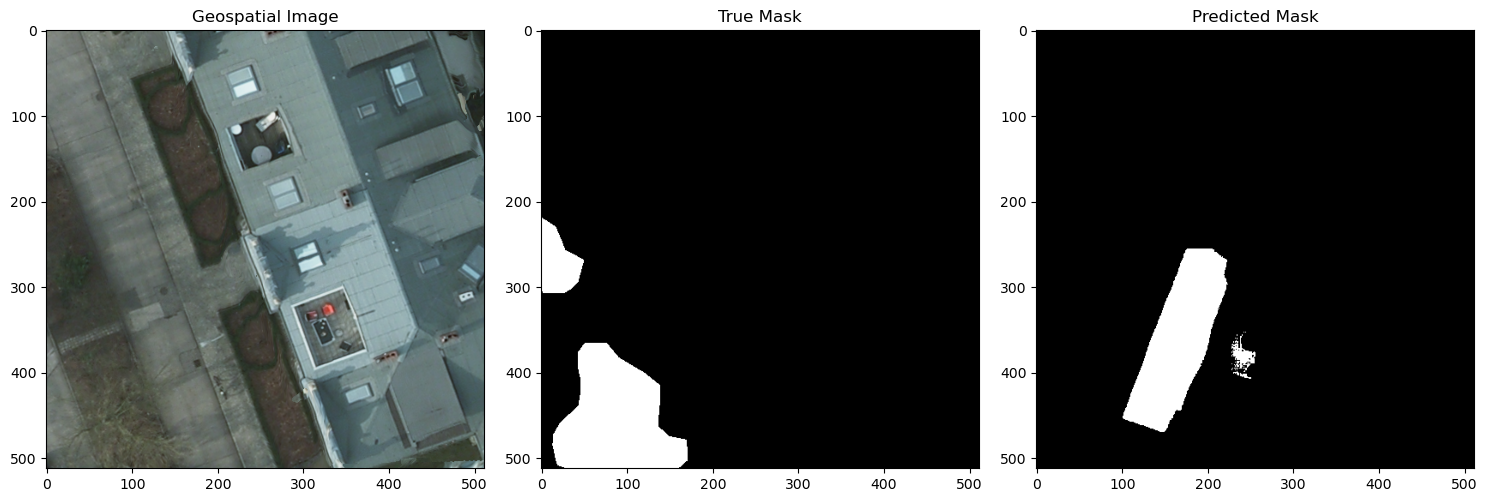

In [44]:
# show one image
id = train_ids[19]
file_prefix = 'top_potsdam_' + id.replace("t","")
img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
mask_path = os.path.join(TRAIN_PATH, id, file_prefix + '_label.tif')
predicted_path = os.path.join(PREDICTED_PATH, file_prefix + '_predicted.tif')
print(img_path, mask_path, predicted_path)

# plot 3 images first actual then label and predicted
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
predicted = cv2.imread(predicted_path)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Geospatial Image')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(predicted)
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()

In [22]:
import sys
sys.path.append('../mask-evaluation')
from main import print_metrics, evaluate_mask
from collections import Counter

In [49]:

data = []

for id in train_ids:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    
    text_prompt = "tree, gras"
    mask_path = os.path.join(TRAIN_PATH, id, file_prefix + '_label.tif')
    predicted_path = os.path.join(PREDICTED_PATH, file_prefix + '_predicted.tif')
    data.append((predicted_path, mask_path))
    

def evaluate_mask_file(base_mask_path: str, predicted_mask_path: str) -> Counter:
    expected = cv2.imread(base_mask_path)
    actual = cv2.imread(predicted_mask_path)
    return evaluate_mask(expected, actual)


res = sum([evaluate_mask_file(base, actual) for base, actual in data], Counter())

print_metrics(res)


Results: 
   accuracy: 72.899 %
         f1:  0.484
     recall:  0.385 (or sensitivity)
  precision:  0.649
specificity:  0.898

TPR: 0.385 | FNR: 0.615
TNR: 0.898 | FPR: 0.102
PPV: 0.649 | FDR: 0.351
NPV: 0.748 | FOR: 0.252
